# KNN on CIFAR-10 from local batch files

- **Student ID** : 2019113634
- **Name** : 조준혁

In [2]:
import os, pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

### Configuration

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
CIFAR_PATH = "/content/drive/MyDrive/컴퓨터비전입문/KNN/cifar-10-batches-py"
RANDOM_STATE = 42
VAL_SIZE = 0.1
K_LIST = [1,3,5,7,9,11,13,15,19,25]

### Load CIFAR-10 Dataset

In [5]:
def _unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='latin1')

def load_cifar10_from_batches(path):
    Xs, ys = [], []
    for i in range(1, 6):
        d = _unpickle(os.path.join(path, f"data_batch_{i}"))
        Xs.append(d['data'])              # (10000, 3072) uint8
        ys += d['labels']                 # list[int]
    X_train = np.vstack(Xs).astype(np.float32)
    y_train = np.array(ys, dtype=np.int64)

    dtest = _unpickle(os.path.join(path, "test_batch"))
    X_test = dtest['data'].astype(np.float32)
    y_test = np.array(dtest['labels'], dtype=np.int64)
    return X_train, y_train, X_test, y_test

X_train_full, y_train_full, X_test, y_test = load_cifar10_from_batches(CIFAR_PATH)

### 0) Preprocessing: Standardize the dataset

In [6]:
def fit_transform_standardize(X_train, X_val_or_test=None):
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xtr = scaler.fit_transform(X_train)
    if X_val_or_test is None:
        return Xtr, scaler
    Xvt = scaler.transform(X_val_or_test)
    return Xtr, Xvt, scaler

### 1) Train/Test split only (k=3, Lasso)

In [7]:
Xtr_tt, Xte_tt, _ = fit_transform_standardize(X_train_full, X_test)
knn_tt = KNeighborsClassifier(n_neighbors=3, p=2)
knn_tt.fit(Xtr_tt, y_train_full)
yp_tt = knn_tt.predict(Xte_tt)

print("Accuracy :", accuracy_score(y_test, yp_tt))
print("Precision(macro):", precision_score(y_test, yp_tt, average='macro'))
print("Recall(macro):   ", recall_score(y_test, yp_tt, average='macro'))
print("F1(macro):       ", f1_score(y_test, yp_tt, average='macro'))

Accuracy : 0.3308
Precision(macro): 0.4336324050647131
Recall(macro):    0.33080000000000004
F1(macro):        0.3186991884061469


### 2) Train/Validation/Test (using validation set to select K, Lasso)

In [8]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, stratify=y_train_full, random_state=RANDOM_STATE
)
Xtr_tv, Xval_tv, _ = fit_transform_standardize(X_tr, X_val)

best_k, best_acc = None, -1.0
for k in K_LIST:
    clf = KNeighborsClassifier(n_neighbors=k, p=2)
    clf.fit(Xtr_tv, y_tr)
    acc = accuracy_score(y_val, clf.predict(Xval_tv))
    if acc > best_acc:
        best_acc, best_k = acc, k

Xfull_std, Xtest_std, _ = fit_transform_standardize(X_train_full, X_test)
knn_best = KNeighborsClassifier(n_neighbors=best_k, p=2)
knn_best.fit(Xfull_std, y_train_full)
yp_best = knn_best.predict(Xtest_std)

print(f"Selected k: {best_k} (val acc={best_acc:.4f})")
print("Test Accuracy :", accuracy_score(y_test, yp_best))
print("Test Precision(macro):", precision_score(y_test, yp_best, average='macro'))
print("Test Recall(macro):   ", recall_score(y_test, yp_best, average='macro'))
print("Test F1(macro):       ", f1_score(y_test, yp_best, average='macro'))

Selected k: 1 (val acc=0.3480)
Test Accuracy : 0.3567
Test Precision(macro): 0.4154069077192811
Test Recall(macro):    0.35669999999999996
Test F1(macro):        0.3521312264637972


### 3) 5-fold Cross-Validation

In [9]:
Xcv_std, _ = fit_transform_standardize(X_train_full)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

acc_means, acc_stds = [], []
for k in K_LIST:
    clf = KNeighborsClassifier(n_neighbors=k, p=2)
    out = cross_validate(
        clf, Xcv_std, y_train_full, cv=skf,
        scoring={'acc':'accuracy','prec':'precision_macro','rec':'recall_macro','f1':'f1_macro'},
        return_train_score=False
    )
    acc_means.append(out['test_acc'].mean())
    acc_stds.append(out['test_acc'].std())

print("Test Accuracy (5-fold CV) :")
for k, m, s in zip(K_LIST, acc_means, acc_stds):
    print(f"k={k:>2} | mean={m:.4f}  std={s:.4f}")

Test Accuracy (5-fold CV) :
k= 1 | mean=0.3410  std=0.0018
k= 3 | mean=0.3251  std=0.0032
k= 5 | mean=0.3321  std=0.0033
k= 7 | mean=0.3328  std=0.0016
k= 9 | mean=0.3320  std=0.0030
k=11 | mean=0.3315  std=0.0019
k=13 | mean=0.3311  std=0.0027
k=15 | mean=0.3313  std=0.0016
k=19 | mean=0.3273  std=0.0030
k=25 | mean=0.3222  std=0.0030


### 4) Plot: CV Accuracy vs K

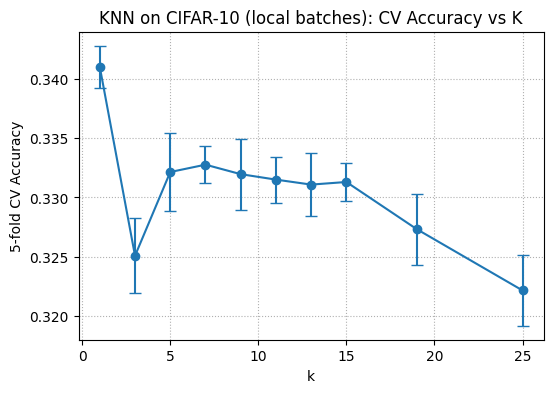

In [10]:
plt.figure(figsize=(6,4))
plt.errorbar(K_LIST, acc_means, yerr=acc_stds, fmt='o-', capsize=4)
plt.xlabel("k")
plt.ylabel("5-fold CV Accuracy")
plt.title("KNN on CIFAR-10 (local batches): CV Accuracy vs K")
plt.grid(True, linestyle=':')
plt.show()